In [239]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [200]:
def l2d(line):
    return " ".join(line.split()).split(" ")

def parse_classification_report(path):
    class_m = {}
    tot_m = {}
    
    if "teacher" in path:
        model = "teacher"
    else:
        model = "student"
    
    with open(path) as file:
        line = file.readline()
        line = file.readline() # skip first line
        line = file.readline()
        while line:
            data = l2d(line)
            
            class_m[data[0]] = {
                "prec": float(data[1]),
                "rec": float(data[2]),
                "f1": float(data[3]),
                "model": model
            }
            line = file.readline()

            if len(line) == 1:
                line = False
                
        line = file.readline()
        tot_m["acc"] = l2d(line)[1]
        line = file.readline()
        tot_m["macro"] = l2d(line)[2:5]
        line = file.readline()
        tot_m["weighted"] = l2d(line)[2:5]
                
    return class_m, tot_m

## All class metrics from all iterations in one plot

In [201]:
folders = ["0_teacher", "0_student", "1_teacher", "1_student", "2_teacher", "2_student"]

contents = []
for f in folders:
    log_dir = "/home/henriklg/master-thesis/code/hyper-kvasir/experiments/model-size/teachb0-studb6/{}/".format(f)
    report_file = log_dir+"classification_report.txt"
    
    class_m, _ = parse_classification_report(report_file)
    contents.append(class_m)

prec = []
rec = []
for content in contents:
    prec += [value["prec"] for key, value in content.items()]
    rec += [value["rec"] for key, value in content.items()]

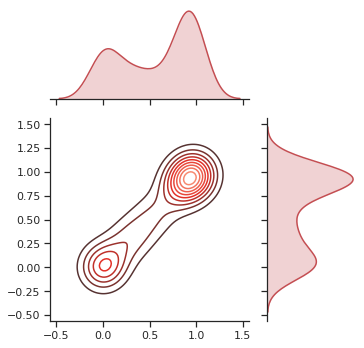

In [202]:
g = sns.JointGrid(rec, rec, height=5, ratio=2)
g = g.plot_joint(sns.kdeplot, cmap="Reds_d")
g = g.plot_marginals(sns.kdeplot, color="r", shade=True)

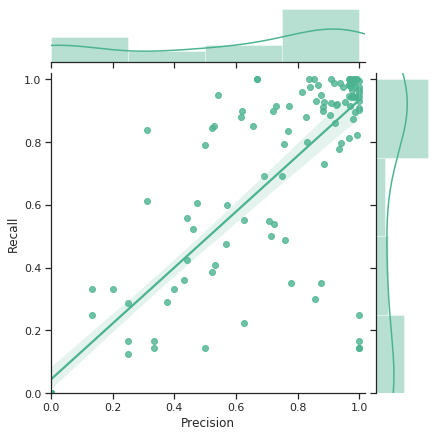

In [203]:
sns.set(style="ticks")

ax = sns.jointplot(prec, rec, height=6, kind="reg", color="#4CB391", xlim=(0,1.02), ylim=(0,1.02) );
# ax.plot_joint(plt.scatter, c="w", s=50, linewidth=1.5, marker="+")
ax = (ax.set_axis_labels("Precision", "Recall"))

plt.savefig("precision_recall.pdf", format="pdf")

In [ ]:
sns.set(style="ticks")

ax = sns.jointplot(prec, rec, height=6, kind="kde", color="#4CB391", xlim=(0,1.02), ylim=(0,1.02) );
ax.plot_joint(plt.scatter, c="w", s=30, linewidth=1.0, marker="o")

ax = (ax.set_axis_labels("Precision", "Recall"))

plt.savefig("precision_recall.pdf", format="pdf")

## Seperate teacher and student class metrics

In [204]:
tfolders = ["0_teacher", "1_teacher", "2_teacher"]
tprec = []
trec = []
tf1 = []

contents = []
for f in tfolders:
    log_dir = "/home/henriklg/master-thesis/code/hyper-kvasir/experiments/model-size/teachb0-studb6/{}/".format(f)
    report_file = log_dir+"classification_report.txt"
    
    contents, _ = parse_classification_report(report_file)
    tprec += [value["prec"] for key, value in contents.items()]
    trec += [value["rec"] for key, value in contents.items()]
    tf1 += [value["f1"] for key, value in contents.items()]


sfolders = ["0_student", "1_student", "2_student"]
sprec = []
srec = []
sf1 = []

contents = []
for f in sfolders:
    log_dir = "/home/henriklg/master-thesis/code/hyper-kvasir/experiments/model-size/teachb0-studb6/{}/".format(f)
    report_file = log_dir+"classification_report.txt"
    
    contents, _ = parse_classification_report(report_file)
    sprec += [value["prec"] for key, value in contents.items()]
    srec += [value["rec"] for key, value in contents.items()]
    sf1 += [value["f1"] for key, value in contents.items()]
    
print ("teacher avg f1 = {:.4f}".format (np.sum(tf1)/len(tf1)))
print ("student avg f1 = {:.4f}".format (np.sum(sf1)/len(sf1)))

teacher avg f1 = 0.5882
student avg f1 = 0.5573


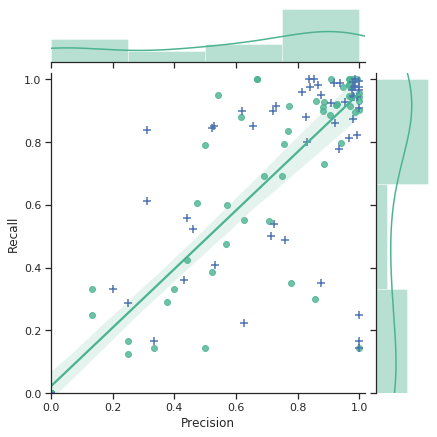

In [205]:
sns.set(style="ticks")

ax = sns.jointplot(tprec, trec, height=6, kind="reg", color="#4CB391", xlim=(0,1.02), ylim=(0,1.02) );
ax.x = sprec
ax.y = srec
ax.plot_joint(plt.scatter, c="b", s=50, linewidth=1.5, marker="+")
ax = (ax.set_axis_labels("Precision", "Recall"))

plt.savefig("precision_recall.pdf", format="pdf")

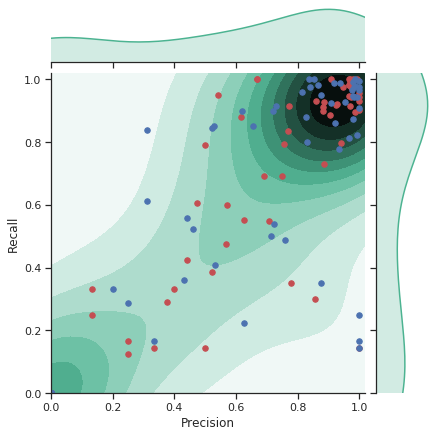

In [206]:
sns.set(style="ticks")

ax = sns.jointplot(tprec, trec, height=6, kind="kde", color="#4CB391", xlim=(0,1.02), ylim=(0,1.02) );
ax.plot_joint(plt.scatter, c="r", s=30, linewidth=1.0, marker="o")
ax.x = sprec
ax.y = srec
ax.plot_joint(plt.scatter, c="b", s=30, linewidth=1.0, marker="o")
ax = ax.set_axis_labels("Precision", "Recall")

plt.savefig("precision_recall_con.pdf", format="pdf")

## Create dataframe

In [207]:
folders = ["0_teacher", "0_student", "1_teacher", "1_student", "2_teacher", "2_student"]

first = True

for f in folders:
    log_dir = "/home/henriklg/master-thesis/code/hyper-kvasir/experiments/model-size/teachb0-studb6/{}/".format(f)
    report_file = log_dir+"classification_report.txt"
    
    contents, _ = parse_classification_report(report_file)
    if first:
        df = pd.DataFrame.from_dict(contents, orient='index')
        first = False
    else: 
        new_df = pd.DataFrame.from_dict(contents, orient='index')
        df = new_df.append(df, ignore_index=True)

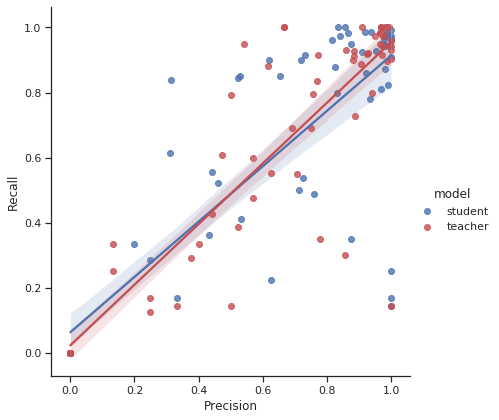

In [209]:
ax = sns.lmplot(x="prec", y="rec", hue="model", data=df, height=6, legend=True, palette=dict(student="b", teacher="r"));
ax = (ax.set_axis_labels("Precision", "Recall"))

plt.savefig("precision_recall_reg.pdf", format="pdf")

### Bar chart

In [210]:
def print_bar_chart(data, conf, title=None, fname=None, figsize=(15,6)):
    """
    Takes in list of data and makes a bar chart of it.
    Dynamically allocates placement for bars.
    """
    folders = ["Teach 0", "Stud 0", "Teach 1", "Stud 1", "Teach 2", "Stud 2"]
    
    x = np.arange(conf["num_classes"])
    width = 0.8      # 1.0 = bars side by side
    width = width/len(data)

    num_bars = len(data)
    if num_bars == 1:
        bar_placement = [0]
    # even number of bars
    elif (num_bars % 2) == 0:
        bar_placement = np.arange(-num_bars/2, num_bars/2+1)    #[-2, -1, 0, 1, 2]
        bar_placement = np.delete(bar_placement, num_bars//2)   #delete 0
        bar_placement = [bar+0.5 if bar<0 else bar-0.5 for bar in bar_placement]
    # odd number of bars
    else:
        bar_placement = np.arange(-np.floor(num_bars/2), np.floor(num_bars/2)+1)

    fig, ax = plt.subplots(figsize=figsize)

    rects = []
    for cnt, (dat, placement) in enumerate(zip(data, bar_placement)):
        rects.append(ax.bar(x+placement*width, dat, width, label=folders[cnt]))

    ax.set_ylabel('F1 score')
    if title:
        title_string = title
        ax.set_title(title_string)
    ax.set_xticks(x)
    ax.set_xticklabels(conf["class_names"])
    ax.set_axisbelow(True)
    ax.legend(loc='upper left');

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=25, ha="right",
                 rotation_mode="anchor")
    plt.grid(axis='y')


    fig.tight_layout()
    if fname:
        plt.savefig('{}/{}.pdf'.format(conf["log_dir"], fname), format='pdf')
    plt.show()

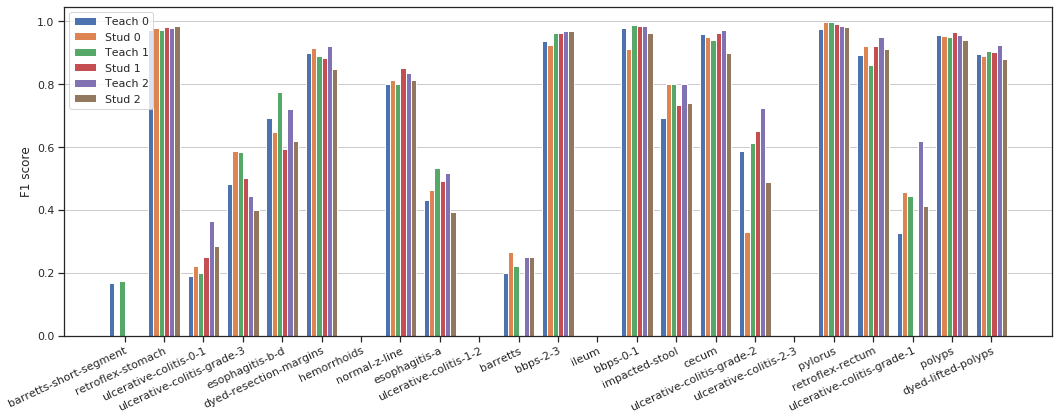

In [211]:
folders = ["0_teacher", "0_student", "1_teacher", "1_student", "2_teacher", "2_student"]

contents = []

for f in folders:
    log_dir = "/home/henriklg/master-thesis/code/hyper-kvasir/experiments/model-size/teachb0-studb6/{}/".format(f)
    report_file = log_dir+"classification_report.txt"
    
    class_m, _ = parse_classification_report(report_file)
    contents.append(class_m)
    
    
f1 = []
for content in contents:
    f1.append([value["f1"] for key, value in content.items()])
    
conf = {"num_classes": 23,
        "class_names": [key for key, value in contents[0].items()],
        "log_dir": "./"}

print_bar_chart(f1, conf, fname="f1-scores")

## Compare model sizes

In [218]:
folders = ["0_teacher", "0_student", "1_teacher", "1_student", "2_teacher", "2_student"]
experiment = "all-b0"
# iters = ["Teach 0", "Stud 0", "Teach 1", "Stud 1", "Teach 2", "Stud 2"]

num_classes = 23
contents = []

for f in folders:
    log_dir = "/home/henriklg/master-thesis/code/hyper-kvasir/experiments/model-size/{}/{}/".format(experiment, f)
    report_file = log_dir+"classification_report.txt"
    content = get_metrics(report_file, num_classes)
    
    _, tot_m = parse_classification_report(report_file)
    contents.append(tot_m)

In [219]:
# Compare weighted and macro precision, recall and f1-score
prec = []
rec = []
f1 = []
acc = []

metric = "weighted"

for idx, i in enumerate(iters):
    content = contents[idx]
    
    acc.append(float(content["acc"]))
    prec.append(float(content[metric][0]))
    rec.append(float(content[metric][1]))
    f1.append(float(content[metric][2]))

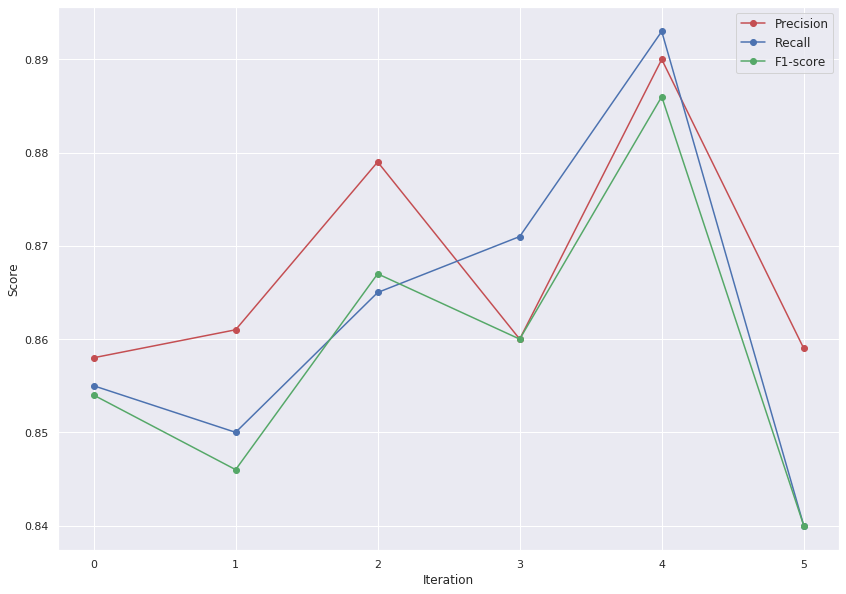

In [240]:
x = list(range(len(folders)))

fig, ax = plt.subplots(figsize=(14,10))
fig = plt.plot(x,prec,'r', x,rec,'b', x,f1,'g', marker='o');
fig = plt.legend(["Precision","Recall","F1-score"], fontsize=12)
fig = plt.xlabel("Iteration")
fig = plt.ylabel("Score")

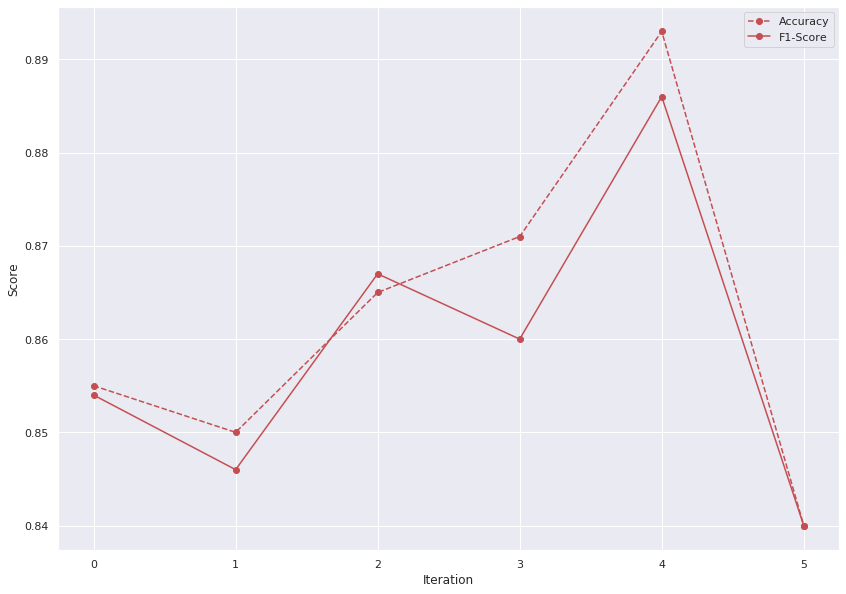

In [255]:
x = list(range(len(folders)))

fig, ax = plt.subplots(figsize=(14,10))
fig = plt.plot(x,acc,'r--', x,f1,'r-', linewidth=1.5, marker='o');
fig = plt.legend(["Accuracy", "F1-Score"])
fig = plt.xlabel("Iteration")
fig = plt.ylabel("Score")

## Compare F1-score for different model sizes

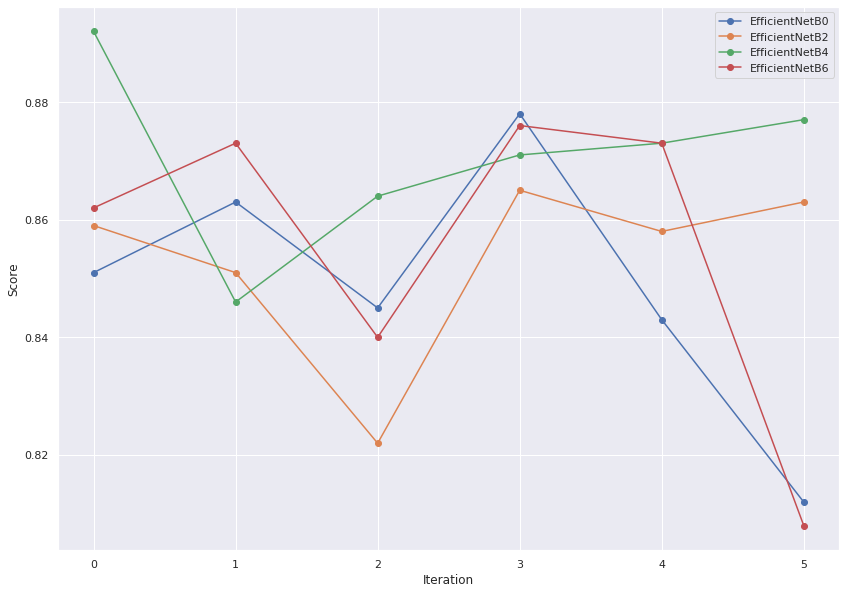

In [264]:
folders = ["0_teacher", "0_student", "1_teacher", "1_student", "2_teacher", "2_student"]
experiments = ["all-b0", "all-b2", "all-b4", "all-b6"]#, "teachb0-studb6"]
legends = ["EfficientNetB0", "EfficientNetB2", "EfficientNetB4", "EfficientNetB6"]

plt_val = []

for exp in experiments:
    
    # parse all classification reports
    contents = []
    for f in folders:
        log_dir = "/home/henriklg/master-thesis/code/hyper-kvasir/experiments/model-size/{}/{}/".format(exp, f)
        report_file = log_dir+"classification_report.txt"
        content = get_metrics(report_file, num_classes)

        _, tot_m = parse_classification_report(report_file)
        contents.append(tot_m)
    
    # get experiment metrics
    prec = []
    rec = []
    f1 = []
    acc = []

    metric = "weighted"
    for idx, i in enumerate(iters):
        content = contents[idx]

        acc.append(float(content["acc"]))
        prec.append(float(content[metric][0]))
        rec.append(float(content[metric][1]))
        f1.append(float(content[metric][2]))
    plt_val.append(f1)
    
    
# Plot the results
fig, ax = plt.subplots(figsize=(14,10))
for ex in plt_val:
    fig = plt.plot(x,ex, linewidth=1.5, marker='o')
fig = plt.legend(legends)
fig = plt.xlabel("Iteration")
fig = plt.ylabel("Score")
plt.savefig("model_sizes.pdf", format="pdf")

## Compare noising student vs normal

In [271]:
# average f1 for every model size
avg = [0, 0, 0, 0, 0, 0]
for i in range(6):
    for j in range(4):
        avg[i] += plt_val[j][i]
        
y = [x/4.0 for x in avg]

In [280]:
folders = ["0_teacher", "0_student", "1_teacher", "1_student", "2_teacher", "2_student"]
experiment = "teachb0-studb6"

contents = []

for f in folders:
    log_dir = "/home/henriklg/master-thesis/code/hyper-kvasir/experiments/model-size/{}/{}/".format(experiment, f)
    report_file = log_dir+"classification_report.txt"
    content = get_metrics(report_file, num_classes)
    
    _, tot_m = parse_classification_report(report_file)
    contents.append(tot_m)

# Compare weighted and macro precision, recall and f1-score
prec = []
rec = []
f1 = []
acc = []

metric = "weighted"
for idx, i in enumerate(iters):
    content = contents[idx]
    
    acc.append(float(content["acc"]))
    prec.append(float(content[metric][0]))
    rec.append(float(content[metric][1]))
    f1.append(float(content[metric][2]))

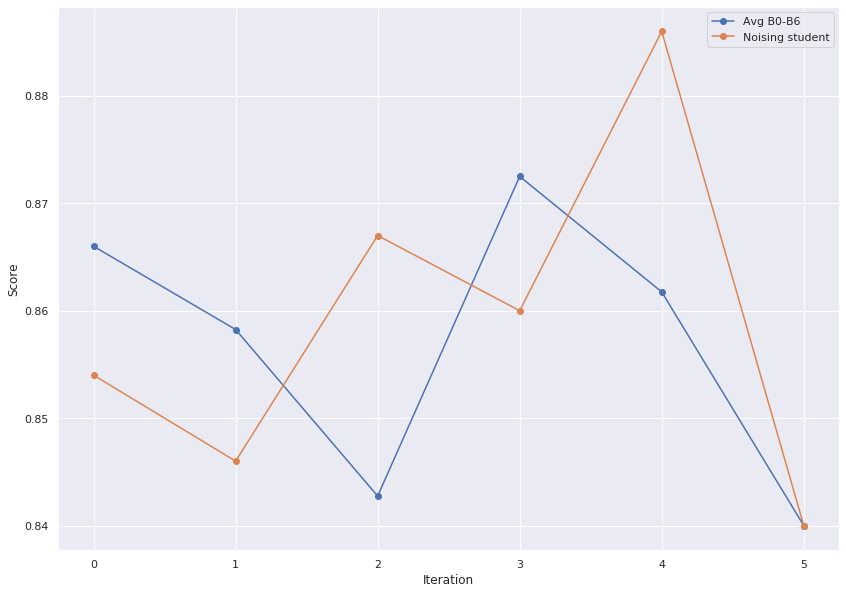

In [285]:
# Plot the results
fig, ax = plt.subplots(figsize=(14,10))
fig = plt.plot(x,y, x,f1, marker="o")
fig = plt.legend(["Avg B0-B6", "Noising student"])
fig = plt.xlabel("Iteration")
fig = plt.ylabel("Score")
# plt.savefig("model_sizes.pdf", format="pdf")